In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sdgym import load_dataset
from sdgym.evaluate import FeatureMaker
from benchmarks import binary_classification_benchmark
from data_utils import data_undersample
from data_utils import label_column
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

## Loading the Gold Data

In [18]:
np.random.seed(17)
gold_train, test, meta, cat, ord = load_dataset('census', benchmark=True)
fm = FeatureMaker(meta, sample=gold_train.shape[0])
gold_train_x, gold_train_y = fm.make_features(gold_train)
test_x, test_y = fm.make_features(test)
gold_labels, index = label_column(gold_train, meta)
print(f"Number of majority labels in train:{sum(gold_train_y==0)}")
print(f"Number of minority labels in train:{sum(gold_train_y==1)}")
print(f"Number of majority labels in test:{sum(test_y==0)}")
print(f"Number of minority labels in test:{sum(test_y==1)}")
print(f"Train table: {gold_train_x.shape}; Test table: {test_x.shape}")



Number of majority labels in train:187141
Number of minority labels in train:12382
Number of majority labels in test:93576
Number of minority labels in test:6186
Train table: (199523, 508); Test table: (99762, 508)


## Load  Saved model and plot

,F1,AP
Original,0.576409,0.603135
UnderSample (IR 1: 2000),0.516046,0.526668
Ctgan,0.508638,0.514141
Smote,0.507283,0.512649


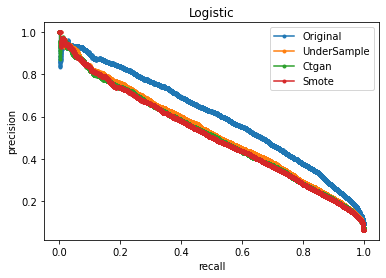

In [27]:
from benchmarks import performance

fig = plt.figure()
ax = plt.subplot('111')
model1 = 'Models/census/logistic/original.pkl'
model2 = 'Models/census/logistic/ir_1_2000.pkl'
model3 = 'Models/census/logistic/syn_1_2000.pkl'
model4 = 'Models/census/logistic/smt_1_2000.pkl'
per1 = performance(model1, test_x, test_y)
per2 = performance(model2, test_x, test_y)
per3 = performance(model3, test_x, test_y)
per4 = performance(model4, test_x, test_y)
ax.plot(per1['recall'], per1['precision'], marker='.', label="Original")
ax.plot(per2['recall'], per2['precision'], marker='.', label="UnderSample")
ax.plot(per3['recall'], per3['precision'], marker='.', label="Ctgan")
ax.plot(per4['recall'], per4['precision'], marker='.', label="Smote")
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.set_title("Logistic")
ax.legend()

df = pd.DataFrame(columns=['F1', 'AP'])
df.loc['Original'] = [per1['f1'], per1['AP']]
df.loc['UnderSample (IR 1: 2000)'] = [per2['f1'], per2['AP']]
df.loc['Ctgan'] = [per3['f1'], per3['AP']]
df.loc['Smote'] = [per4['f1'], per4['AP']]
df = df.style.set_caption("Benchmark: Census dataset")
display(df)




In [15]:

per2['thresholds'].shape

(68036,)